<a href="https://colab.research.google.com/github/alimanbg/Meat-Consumption-Kyrgyzstan/blob/main/MeatConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from google.colab import drive
drive.mount('/content/drive')

# Set the root folder where your file is located
data_root = '/content/drive/My Drive/Meat Consumption'

# Full path to your CSV file
file_path = f'{data_root}/SurveyDataTranslatedAnon.csv'

# Load CSV into DataFrame (corrected to sep=',' for comma-separated values)
df = pd.read_csv(file_path, sep=',', dtype=str)

# Quick check: Print columns and first few rows to verify loading
print("Columns in DataFrame:", df.columns.tolist())
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns in DataFrame: ['Age', 'Gender', 'Frequency', 'Types of Meat', 'Purchase Place', 'Significance of Meat Source', 'Are you worried about the impact of meat consumption on the environment?', 'How often do you purchase from local farmers?', 'Do you want to decrease your meat consumption?', 'Reasons', 'Does anyone you know live in the countryside?', 'Does anyone you know use "tezek"?', 'How do you process "tezek"?', 'Do you add other materials to "tezek"?', 'How much did u save by using "tezeks?', 'What do you feed your livestock?', 'Do you think feeding livestock leftovers decreases monthly expenditure?', 'Do you process leftovers before feeding livestock>', 'Do you know of other sustainable practices?', 'How often do you here of these practices from your relatives?', 'Did you witness or help with these pratcies, how?', 'Are these practices taught at any s

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency, f_oneway
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Remove the legend rows (assuming rows 53+ are descriptions)
df = df.iloc[:52]  # Keep only the first 52 rows (data rows)

# Define mappings based on the legends
mappings = {
    'Are you worried about the impact of meat consumption on the environment?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'How often do you purchase from local farmers?': {'Never - 0': 0, 'Rarely - 1': 1, 'Sometimes - 2': 2, 'Always - 3': 3},
    'Do you want to decrease your meat consumption?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'Reasons': {'Health - 1': 1, 'Environment - 2': 2, 'No - 0': 0},  # Note: This is multi-select, handle separately
    'Does anyone you know live in the countryside?': {'0 - No': 0, '1 - Yes': 1},
    'Does anyone you know use "tezek"?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'How do you process "tezek"?': {'Drying - 1': 1, 'Composting - 2': 2, 'Dont know - 0': 0},
    'Do you add other materials to "tezek"?': {'0 - No': 0, '1 - Yes': 1},
    'What do you feed your livestock?': {'Fruit or green leftovers - 1': 1, 'Food leftovers - 2': 2, 'Graden leftovers - 3': 3, 'Wheat - 4': 4, 'Bread leftovers - 5': 5, 'Other - 0': 0},  # Multi-select
    'Do you think feeding livestock leftovers decreases monthly expenditure?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'Do you process leftovers before feeding livestock': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'Do you know of other sustainable practices?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'How often do you here of these practices from your relatives?': {'Never - 0': 0, 'Rarely - 1': 1, 'Sometimes - 2': 2, 'Always - 3': 3},
    'Did you witness or help with these pratcies, how?': {'Dont know - 0': 0, 'Observation - 2': 2, 'Hands on practice - 1': 1},
    'Are these practices taught at any seasons or festivals?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'Who are responsible for dung and composting?': {'Elderly - 1': 1, 'Women - 2': 2, 'Men - 3': 3, 'Youth - 4': 4},
    'How are these practices passed to other generations?': {'Dont know - 0': 0, 'Hands on practice - 1': 1, 'Observation - 2': 2},
    'Do you think these practices should be spread wider?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2},
    'Would you support events and festivals to support these practices?': {'0 - No': 0, '1 - Yes': 1, '2 - Maybe': 2}
}

# Function to map values
def map_values(column, mapping):
    if column.name in mapping:
        return column.map(mapping).fillna(column)  # Keep original if not in mapping
    return column

# Apply mappings
for col in mappings:
    if col in df.columns:
        df[col] = map_values(df[col], mappings[col])

# Convert mapped columns to numeric (to handle any remaining strings like '0', '1', '2')
for col in mappings:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle multi-select columns (e.g., Reasons, What do you feed your livestock?)
# Split by comma and convert to lists, then use MultiLabelBinarizer for one-hot encoding
multi_select_cols = ['Reasons', 'What do you feed your livestock?']
for col in multi_select_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.split(', ')
        mlb = MultiLabelBinarizer()
        encoded = pd.DataFrame(mlb.fit_transform(df[col]), columns=[f"{col}_{cls}" for cls in mlb.classes_], index=df.index)
        df = pd.concat([df, encoded], axis=1)
        df.drop(col, axis=1, inplace=True)

# Convert 'Types of Meat' to one-hot encoded columns
if 'Types of Meat' in df.columns:
    df['Types of Meat'] = df['Types of Meat'].astype(str).str.split(', ')
    mlb_meat = MultiLabelBinarizer()
    meat_encoded = pd.DataFrame(mlb_meat.fit_transform(df['Types of Meat']), columns=[f"Meat_{cls}" for cls in mlb_meat.classes_], index=df.index)
    df = pd.concat([df, meat_encoded], axis=1)
    df.drop('Types of Meat', axis=1, inplace=True)

# Convert numerical columns to float/int where possible
numerical_cols = ['Frequency', 'Significance of Meat Source', 'How much did u save by using "tezeks?', 'How often do you here of these practices from your relatives?']
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle 'How much did u save...' which has strings like '30-40%', convert to numeric (e.g., average)
def convert_savings(x):
    if isinstance(x, str):
        if '%' in x:
            nums = [int(n) for n in x.replace('%', '').split('-') if n.isdigit()]
            return np.mean(nums) if nums else np.nan
        elif x.isdigit():
            return float(x)
    return np.nan
if 'How much did u save by using "tezeks?' in df.columns:
    df['How much did u save by using "tezeks?'] = df['How much did u save by using "tezeks?'].apply(convert_savings)

# Fill missing values with mode for categorical, mean for numerical
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Convert Age and Gender to categorical
df['Age'] = df['Age'].astype('category')
df['Gender'] = df['Gender'].astype('category')

print("Data cleaned. Shape:", df.shape)
print(df.head())

Data cleaned. Shape: (52, 39)
     Age  Gender  Frequency        Purchase Place  \
0  18-25  Female        1.0           wet markets   
1  26-35  Female        7.0        animal markets   
2  18-25    Male        5.0  self owned lifestock   
3  18-25  Female        7.0          supermarkets   
4  18-25  Female        3.0           wet markets   

   Significance of Meat Source  \
0                          2.0   
1                          3.0   
2                          5.0   
3                          5.0   
4                          5.0   

   Are you worried about the impact of meat consumption on the environment?  \
0                                                0.0                          
1                                                0.0                          
2                                                1.0                          
3                                                1.0                          
4                                                1.

In [62]:
# Summary for numerical columns
numerical_summary = df.select_dtypes(include=[np.number]).describe()
print("Numerical Summary:")
print(numerical_summary)

# Summary for categorical columns
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
for col in categorical_cols:
    print(f"\n{col} Frequencies:")
    print(df[col].value_counts())

Numerical Summary:
       Frequency  Significance of Meat Source  \
count  52.000000                    52.000000   
mean    4.333333                     4.019608   
std     2.045240                     1.162995   
min     1.000000                     1.000000   
25%     3.000000                     3.000000   
50%     3.666667                     4.009804   
75%     7.000000                     5.000000   
max     7.000000                     5.000000   

       Are you worried about the impact of meat consumption on the environment?  \
count                                          52.000000                          
mean                                            1.058824                          
std                                             0.849723                          
min                                             0.000000                          
25%                                             0.000000                          
50%                                      

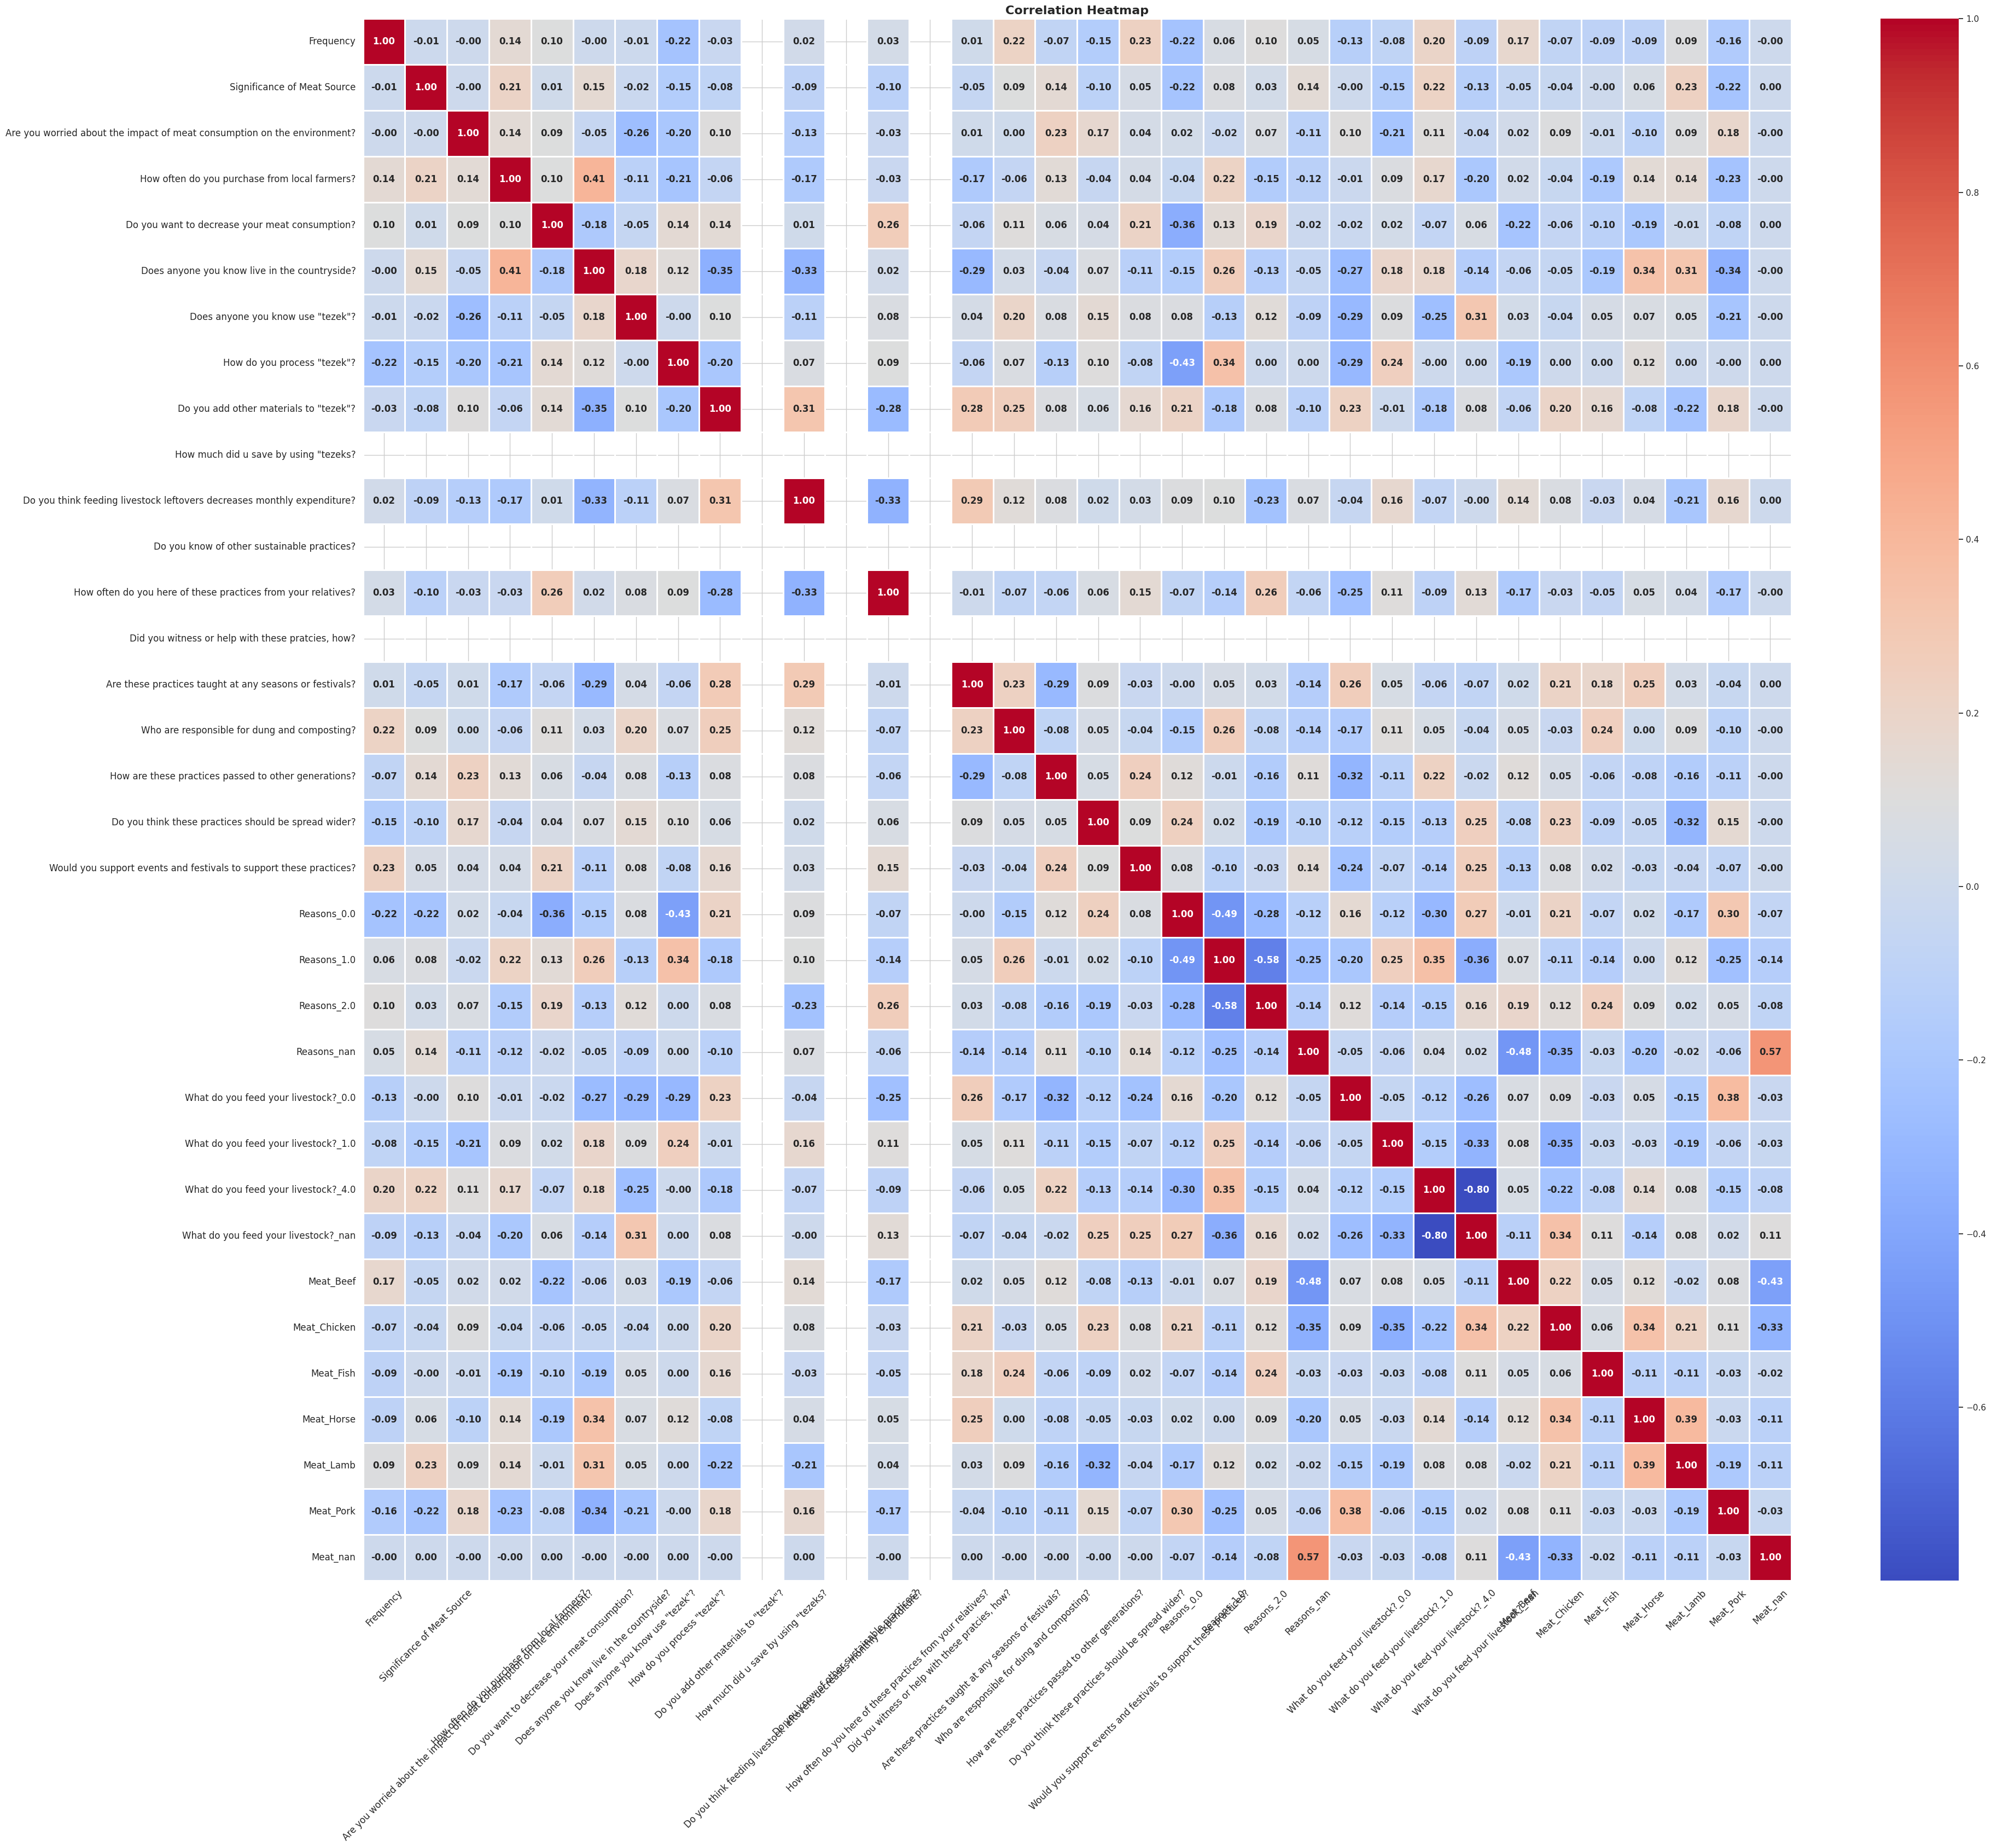

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.select_dtypes(include=[np.number]).corr()
num_vars = corr_matrix.shape[0]

plt.figure(figsize=(num_vars * 1.2, num_vars * 1.2))  # scale figure size by variable count

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    annot_kws={"size": 12, "weight": "bold"},
    square=False,  # allow rectangular cells to fit text better
    linewidths=0.8,
    linecolor='white',
    cbar=True  # optional: set False to save space
)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title("Correlation Heatmap", fontsize=16, weight='bold')

plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.2)  # leave space for labels

plt.show()


Grouped Analysis:
     Age  Gender  \
0   0-18  Female   
1   0-18    Male   
2  18-25  Female   
3  18-25    Male   
4  26-35  Female   
5  26-35    Male   
6  36-45  Female   
7  36-45    Male   
8  46-60  Female   
9  46-60    Male   

   Are you worried about the impact of meat consumption on the environment?  \
0                                           2.000000                          
1                                           2.000000                          
2                                           1.002353                          
3                                           1.000000                          
4                                           0.500000                          
5                                                NaN                          
6                                           1.400000                          
7                                           0.000000                          
8                                           0.0000

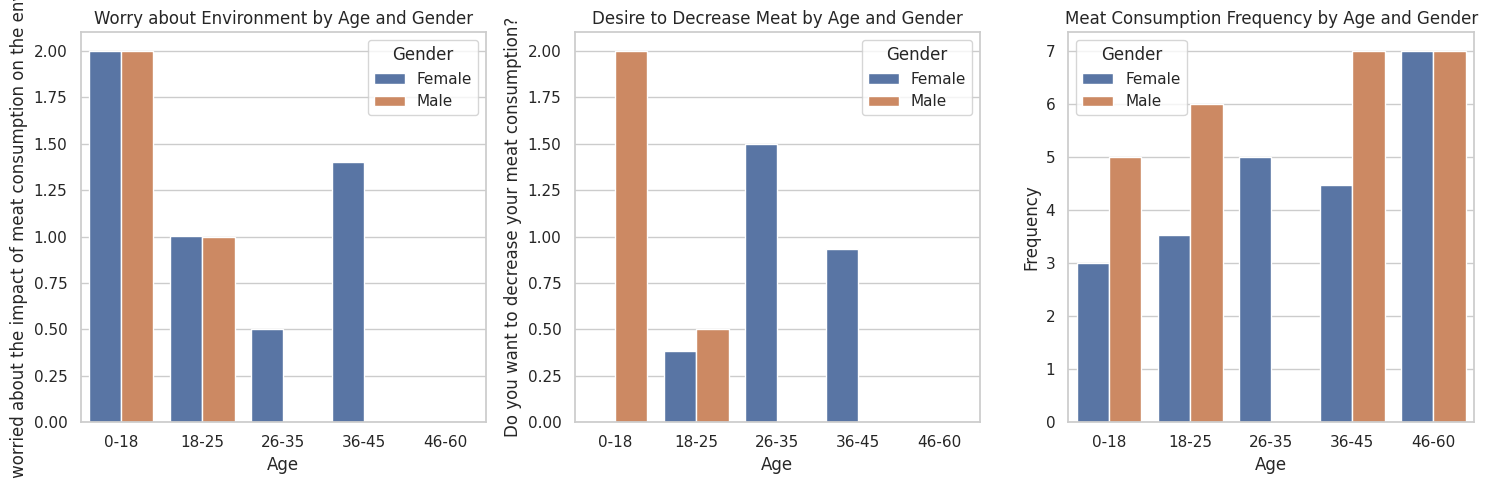

In [64]:
# Group by Age and Gender for key variables
grouped = df.groupby(['Age', 'Gender']).agg({
    'Are you worried about the impact of meat consumption on the environment?': 'mean',
    'Do you want to decrease your meat consumption?': 'mean',
    'Frequency': 'mean'
}).reset_index()
print("Grouped Analysis:")
print(grouped)

# Visualize grouped means
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=grouped, x='Age', y='Are you worried about the impact of meat consumption on the environment?', hue='Gender', ax=axes[0])
axes[0].set_title('Worry about Environment by Age and Gender')
sns.barplot(data=grouped, x='Age', y='Do you want to decrease your meat consumption?', hue='Gender', ax=axes[1])
axes[1].set_title('Desire to Decrease Meat by Age and Gender')
sns.barplot(data=grouped, x='Age', y='Frequency', hue='Gender', ax=axes[2])
axes[2].set_title('Meat Consumption Frequency by Age and Gender')
plt.tight_layout()
plt.show()

In [65]:
# Chi-square test: Gender vs. Worry about environment
contingency = pd.crosstab(df['Gender'], df['Are you worried about the impact of meat consumption on the environment?'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square test for Gender vs. Worry: Chi2={chi2:.2f}, p={p:.4f}")

# ANOVA: Age groups vs. Frequency
age_groups = [df[df['Age'] == age]['Frequency'].dropna() for age in df['Age'].cat.categories]
f_stat, p_anova = f_oneway(*age_groups)
print(f"ANOVA for Age vs. Frequency: F={f_stat:.2f}, p={p_anova:.4f}")

Chi-square test for Gender vs. Worry: Chi2=1.51, p=0.6808
ANOVA for Age vs. Frequency: F=1.92, p=0.1231


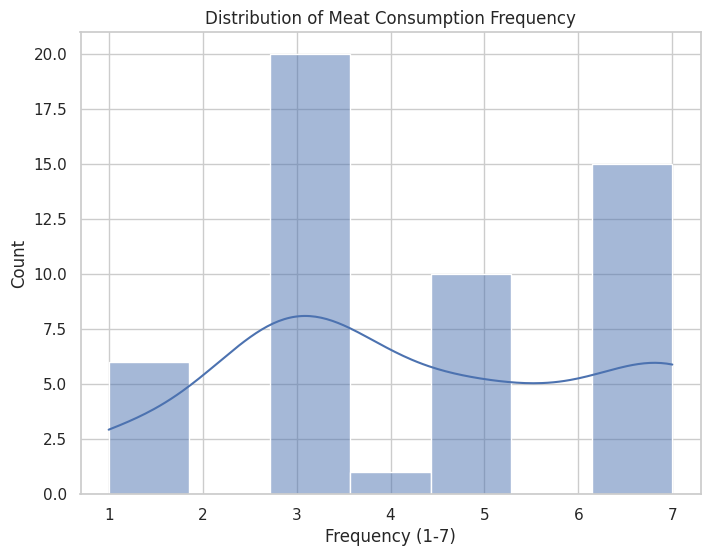

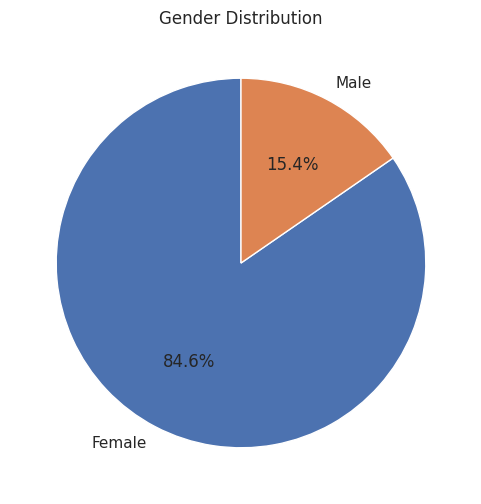

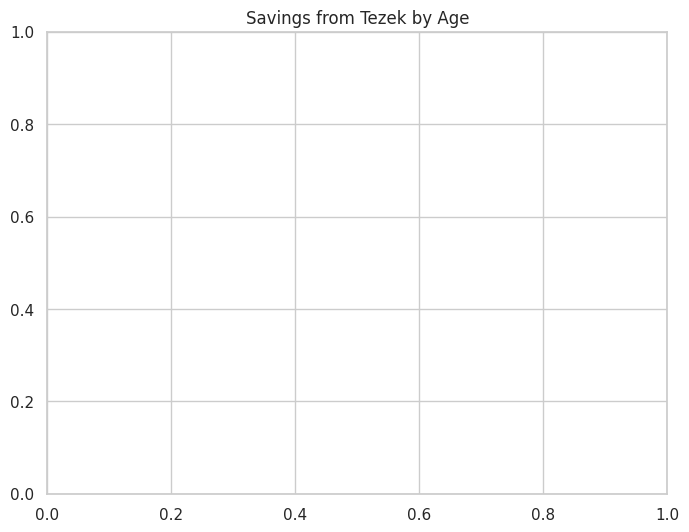

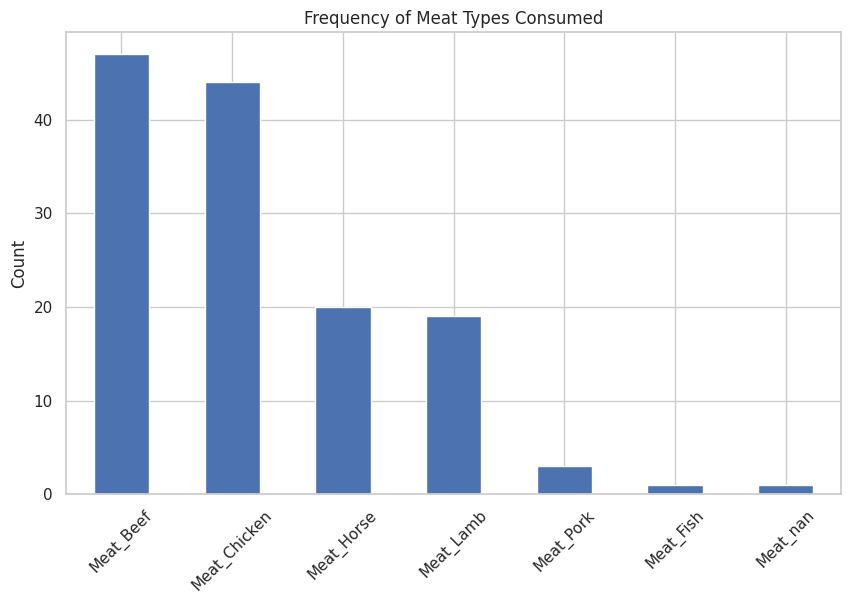

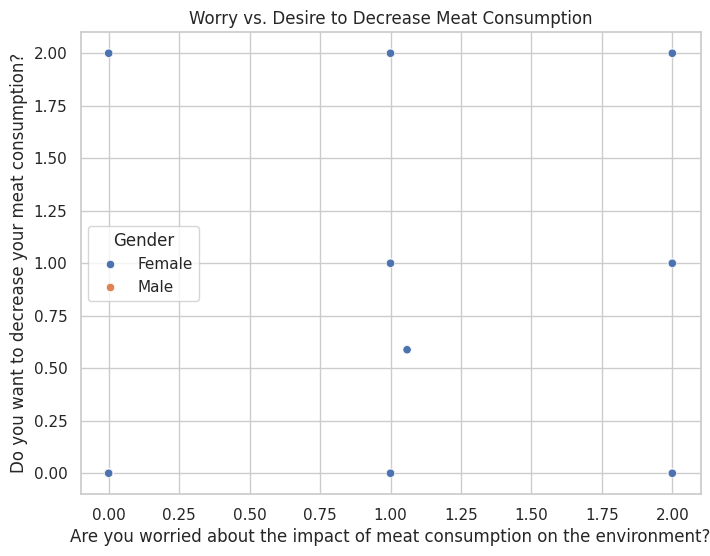

In [66]:
# Histogram of Frequency
plt.figure(figsize=(8, 6))
sns.histplot(df['Frequency'], bins=7, kde=True)
plt.title('Distribution of Meat Consumption Frequency')
plt.xlabel('Frequency (1-7)')
plt.ylabel('Count')
plt.show()

# Pie chart for Gender
plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

# Box plot for Savings by Age (drop NaNs to avoid errors)
df_clean = df.dropna(subset=['How much did u save by using "tezeks?'])
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_clean, x='Age', y='How much did u save by using "tezeks?')
plt.title('Savings from Tezek by Age')
plt.show()

# Bar chart for Meat Types (using one-hot encoded columns)
meat_cols = [col for col in df.columns if col.startswith('Meat_')]
meat_counts = df[meat_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
meat_counts.plot(kind='bar')
plt.title('Frequency of Meat Types Consumed')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Scatter plot: Worry vs. Desire to Decrease
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Are you worried about the impact of meat consumption on the environment?', y='Do you want to decrease your meat consumption?', hue='Gender')
plt.title('Worry vs. Desire to Decrease Meat Consumption')
plt.show()

In [67]:
# Example for "How can we spread these practices more?"
text_col = 'How can we spread these practices more?'
if text_col in df.columns:
    text_data = df[text_col].dropna().str.lower()
    words = ' '.join(text_data).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(10)
    print("Top 10 Words in Spread Practices Responses:")
    for word, freq in common_words:
        print(f"{word}: {freq}")

    # Word cloud (requires wordcloud library; install if needed: !pip install wordcloud)
    # from wordcloud import WordCloud
    # wordcloud = WordCloud(width=800, height=400).generate(' '.join(words))
    # plt.figure(figsize=(10, 5))
    # plt.imshow(wordcloud, interpolation='bilinear')
    # plt.axis('off')
    # plt.title('Word Cloud for Spreading Practices')
    # plt.show()

Top 10 Words in Spread Practices Responses:
through: 9
and: 9
i: 9
don’t: 8
know: 8
the: 6
social: 5
it: 5
in: 5
to: 4


Regression Coefficients:
Are you worried about the impact of meat consumption on the environment?: 0.26
Do you want to decrease your meat consumption?: 0.34
Age_18-25: 0.82
Age_26-35: 2.33
Age_36-45: 1.86
Age_46-60: 3.49
Gender_Male: 2.21
R-squared: -0.23
Mean Squared Error: 3.99


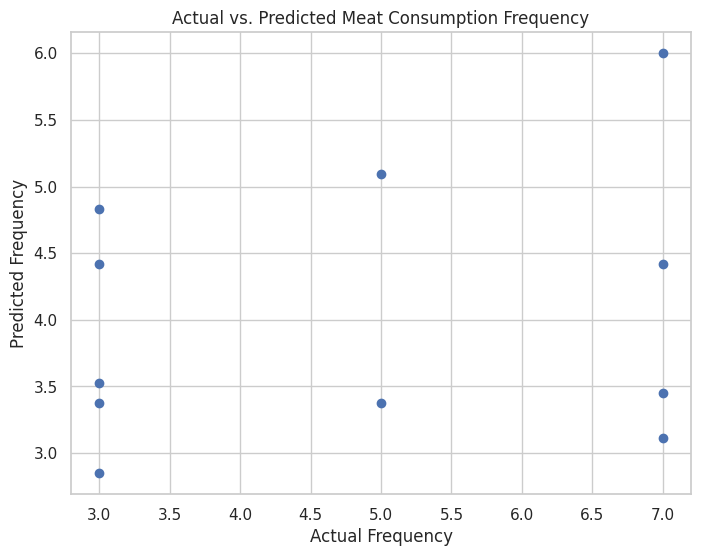

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Example: Predict 'Frequency' (meat consumption) based on worry, desire to decrease, and demographics
features = ['Are you worried about the impact of meat consumption on the environment?',
            'Do you want to decrease your meat consumption?', 'Age', 'Gender']
X = pd.get_dummies(df[features], drop_first=True)  # Encode categoricals
y = df['Frequency'].dropna()
X = X.loc[y.index]  # Align indices

# Split and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Results
print("Regression Coefficients:")
for feat, coef in zip(X.columns, model.coef_):
    print(f"{feat}: {coef:.2f}")
print(f"R-squared: {r2_score(y_test, y_pred):.2f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")

# Visualize predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Frequency')
plt.ylabel('Predicted Frequency')
plt.title('Actual vs. Predicted Meat Consumption Frequency')
plt.show()

In [69]:
from scipy.stats import ttest_ind, mannwhitneyu

# T-test: Worry levels by Gender
male_worry = df[df['Gender'] == 'Male']['Are you worried about the impact of meat consumption on the environment?'].dropna()
female_worry = df[df['Gender'] == 'Female']['Are you worried about the impact of meat consumption on the environment?'].dropna()
t_stat, p_val = ttest_ind(male_worry, female_worry)
print(f"T-test for Worry by Gender: t={t_stat:.2f}, p={p_val:.4f}")

# Mann-Whitney: Savings by Age (if not normally distributed)
age_18_25 = df[df['Age'] == '18-25']['How much did u save by using "tezeks?'].dropna()
age_26_35 = df[df['Age'] == '26-35']['How much did u save by using "tezeks?'].dropna()
u_stat, p_val_u = mannwhitneyu(age_18_25, age_26_35)
print(f"Mann-Whitney for Savings by Age (18-25 vs. 26-35): U={u_stat:.2f}, p={p_val_u:.4f}")

T-test for Worry by Gender: t=-1.12, p=0.2679
Mann-Whitney for Savings by Age (18-25 vs. 26-35): U=nan, p=nan


Explained Variance Ratio: [0.14165482 0.11545601]


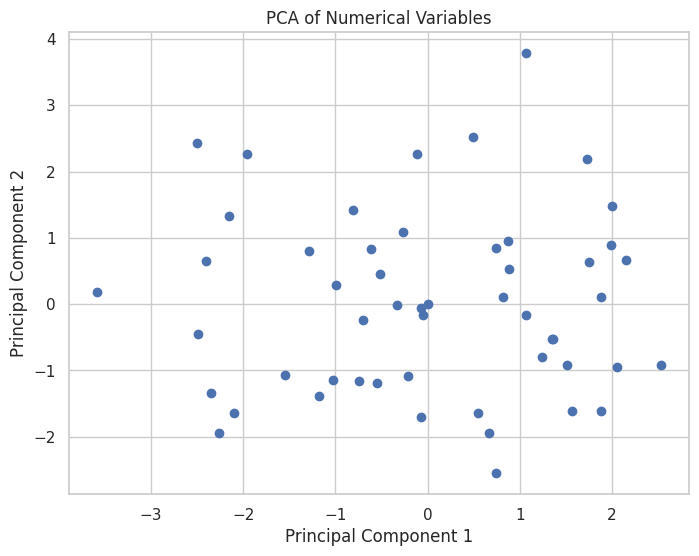

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Select numerical columns for PCA, but exclude one-hot encoded columns if they have many NaNs
num_cols = [col for col in df.select_dtypes(include=[np.number]).columns if not col.startswith(('Meat_', 'Reasons_', 'What do you feed your livestock?_'))]
X_pca = df[num_cols]

# Impute NaNs using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_pca)

# Ensure we have data
if X_imputed.shape[0] == 0:
    print("No data available for PCA after imputation.")
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    # Explained variance
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)

    # Visualize PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Numerical Variables')
    plt.show()


In [72]:
# Export key results
numerical_summary.to_csv('/content/drive/My Drive/Meat Consumption/numerical_summary.csv')
corr_matrix.to_csv('/content/drive/My Drive/Meat Consumption/correlation_matrix.csv')
grouped.to_csv('/content/drive/My Drive/Meat Consumption/grouped_analysis.csv')
print("Results exported to Google Drive.")

Results exported to Google Drive.
